In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from multiprocess import Pool

In [2]:
# function for state normalization
def normalize(psi):
    norm = np.sqrt(np.sum(np.absolute(psi)**2))
    return psi/norm

In [3]:
#checkerboard anzatz
def variational_circuit(weights, num_layers, num_qubits):
    ind = 0
    for l in range(num_layers):
        for sublayer in range(2):
            for j in range(sublayer, num_qubits - 1, 2):
                qml.RZ(weights[ind], wires=j); ind += 1
                qml.RZ(weights[ind], wires=j+1); ind += 1
                qml.IsingXX(weights[ind], wires=[j, j + 1]); ind += 1
                qml.RX(weights[ind], wires=j); ind += 1   
                qml.RX(weights[ind], wires=j+1); ind += 1   
            if sublayer==1 and num_qubits%2==0:
                qml.RZ(weights[ind], wires=0); ind += 1
                qml.RZ(weights[ind], wires=num_qubits-1); ind += 1
                qml.IsingXX(weights[ind], wires=[0, num_qubits-1]); ind += 1
                qml.RX(weights[ind], wires=0); ind += 1   
                qml.RX(weights[ind], wires=num_qubits-1); ind += 1   

In [4]:
class Variational_amplitude_embedding:
         
    def __init__(self, num_qubits, num_layers, optimizer):
        
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        if num_qubits%2 == 0:
            self.num_weights = 5*num_qubits*num_layers
        else:
            self.num_weights = 5*(num_qubits-1)*num_layers
        self.optimizer = optimizer
        self.device = qml.device("default.qubit", wires=self.num_qubits)
        
    def prepare_state(self, weights):
        @qml.qnode(self.device)
        def state_circuit(weights):
            variational_circuit(weights, self.num_layers, self.num_qubits)
            return qml.state()
        return state_circuit(weights)
    
    def cost_function(self, weights, target_state):
        overlap=np.inner(self.prepare_state(weights), target_state)
        return -np.absolute(overlap)**2
    
    def init_weights(self, seed):
        if seed != None:
            np.random.rand(seed)
        return 2*np.pi*np.random.rand(self.num_weights, requires_grad=True)  # Random initial weights
        
    def optimize(self, target_state, steps, seed=None):
        self.costs_list = []
        weights=self.init_weights(seed=seed)
        for i in range(steps):
            weights, cost = self.optimizer.step_and_cost(self.cost_function, weights, target_state=target_state)
            if (i + 1) % 10 == 0:
                self.costs_list.append(cost)
        self.final_state = self.prepare_state(weights)
        self.weights = weights
        return weights, self.costs_list

In [ ]:
### example of use ###

num_layers=15 #number of an anzatz layers
num_qubits=6

#create target state
np.random.seed(0)
psi = normalize(np.random.uniform(low=-1, high=1, size=2**num_qubits, requires_grad=False))
        
optimizer=qml.GradientDescentOptimizer(0.01) #initialize optimizer
var_amp_emb=Variational_amplitude_embedding(num_qubits, num_layers, optimizer) #create the class for variational embedding
weights, cost = var_amp_emb.optimize(psi, steps=1000, seed=0) #optimize variational circuit for amplitude embedding

In [6]:
# the function which repeats variational embedding multiple times
def job(num_qubits, num_layers, optimizer, n_repeat, steps):
    res_list = np.empty((n_repeat, steps//10))
    var_amp_emb=Variational_amplitude_embedding(num_qubits, num_layers, optimizer)
    for i in range(n_repeat):
        np.random.seed(i)
        psi = normalize(np.random.uniform(low=-1, high=1, size=2**num_qubits, requires_grad=False))
        _, cost_list = var_amp_emb.optimize(psi, steps, seed=i)
        res_list[i] = cost_list
    return res_list

In [ ]:
num_qubits_list=[2, 4, 6] #list of qubits to loop
num_layers_list=[1, 3, 5, 7, 10, 15] #list of layers to loop
optimizer=qml.GradientDescentOptimizer(0.01) #optimizer
n_repeat=100 
steps=1000

res_list = []

with Pool() as mp_pool: #parallel execution
    
    for nq, num_qubits in enumerate(num_qubits_list):
        for nl, num_layers in enumerate(num_layers_list):
            res_list += [ mp_pool.apply_async(job, (num_qubits, num_layers, optimizer, n_repeat, steps))]

    mp_pool.close()
    mp_pool.join()

In [8]:
#retrieve the data
res_list = [res.get() for res in res_list]

In [10]:
#data for a plot
results = np.empty((len(num_qubits_list), len(num_layers_list), n_repeat, steps//10))
for nq in range(len(num_qubits_list)):
    for nl in range(len(num_layers_list)):
        results[nq, nl] = res_list[nq*len(num_layers_list)+nl]
        
means = np.mean(results, axis=2)[:, :, -1]
stds = np.std(results, axis=2)[:, :, -1]

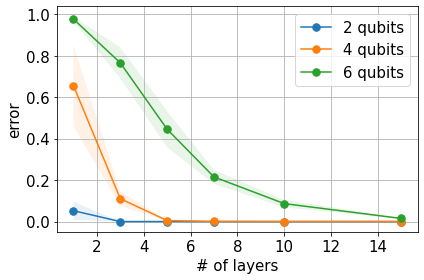

In [34]:
#final plots
f, ax1 = plt.subplots(1,1, figsize = (6,4))

for nq, num_qubits in enumerate(num_qubits_list):
    ax1.plot(num_layers_list, 1+means[nq], '.-',markersize=15,label=f'{num_qubits} qubits' )
    ax1.fill_between(num_layers_list, 1+means[nq]-stds[nq], 1+means[nq]+stds[nq], alpha=0.1)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('# of layers', fontsize = 15 )
ax1.set_ylabel('error', fontsize = 15)

ax1.legend(fontsize = 15, loc='upper right')
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.savefig('variational_approach.pdf')